# 📰 Fake News Detection Dataset

This notebook uses the [Fake News Detection dataset](https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection) from Kaggle, which contains labeled news articles for building and evaluating fake news classifiers.

# 📦 Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ML & NLP Libraries

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2

ML Models and Evaluation

In [4]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score


# Load Dataset

In [5]:
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")
print(f"Fake.csv shape: {fake_df.shape[0]} rows, {fake_df.shape[1]} columns")
print(f"True.csv shape: {true_df.shape[0]} rows, {true_df.shape[1]} columns")

Fake.csv shape: 23481 rows, 4 columns
True.csv shape: 21417 rows, 4 columns


In [6]:
print('Fake News DataFrame:')
print(fake_df.head())
fake_df.info()

print('\nTrue News DataFrame:')
print(true_df.head())
true_df.info()
# Combine the datasets


Fake News DataFrame:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column

Add labels

In [7]:
fake_df['label'] = 0  # Fake
true_df['label'] = 1  # True

# Data Pre-processing

Combine Dataset

In [22]:
df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)
print(f"Combined dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

Combined dataset shape: 44898 rows, 5 columns


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


Handle Missing Values

In [9]:
# Drop nulls if any
df.dropna(inplace=True)

# Combine title + text (optional)
df['content'] = df['title'] + " " + df['text']
df['content'] = df['content'].str.lower().str.replace(r"[^a-zA-Z\s]", "", regex=True)

In [10]:
print("Missing values in each column:")
print(df.isnull().sum())
print("\nPercentage of missing values in each column:")
print((df.isnull().mean() * 100).round(2))

Missing values in each column:
title      0
text       0
subject    0
date       0
label      0
content    0
dtype: int64

Percentage of missing values in each column:
title      0.0
text       0.0
subject    0.0
date       0.0
label      0.0
content    0.0
dtype: float64


Fix Outliers

In [11]:
min_length = 10
initial_count = len(df)
df = df[df['content'].str.len() >= min_length]
print(f"Removed {initial_count - len(df)} rows with empty or very short content (less than {min_length} characters).")

max_length = df['content'].str.len().quantile(0.99)
df['content'] = df['content'].apply(lambda x: x[:int(max_length)])
print(f"Capped article length at {int(max_length)} characters (99th percentile).")

Removed 0 rows with empty or very short content (less than 10 characters).
Capped article length at 9044 characters (99th percentile).


# Features & Labels

In [12]:
X = df['content']
y = df['label']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

🔹 Feature Selection

In [13]:
# Vectorize text data
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
print(f"X_train_vec shape: {X_train_vec.shape}")
print(f"X_test_vec shape: {X_test_vec.shape}")

X_train_vec shape: (35918, 10000)
X_test_vec shape: (8980, 10000)


In [14]:
selector = SelectKBest(chi2, k=5000)
X_train_sel = selector.fit_transform(X_train_vec, y_train)
X_test_sel = selector.transform(X_test_vec)

🔹 Normalization

In [15]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

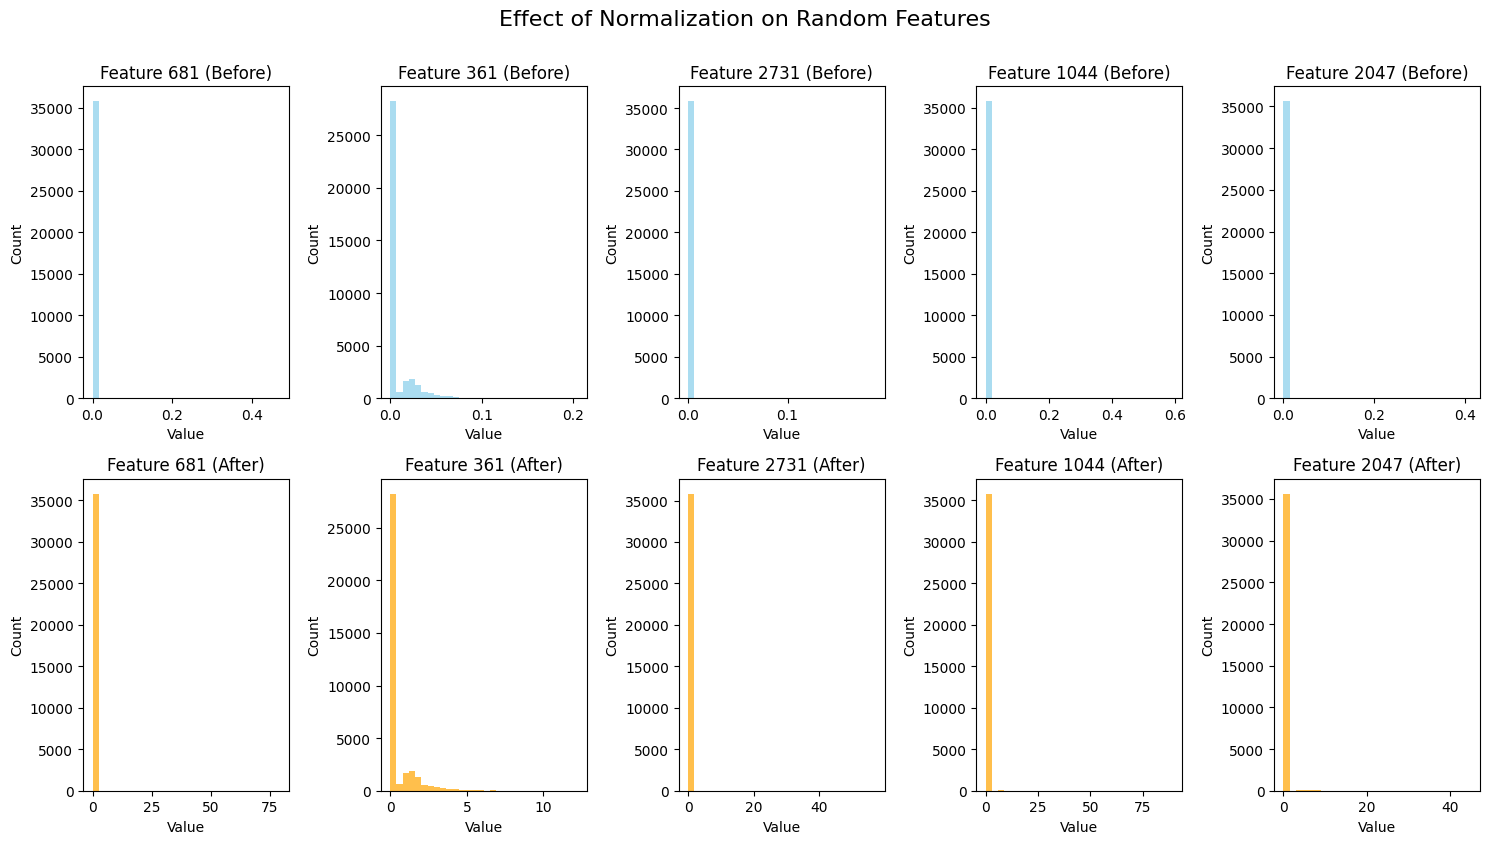

In [16]:
# Visualize normalization effect on feature distributions
import random

# Select a random sample of features to plot
num_features = 5
feature_indices = random.sample(range(X_train_sel.shape[1]), num_features)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(feature_indices):
    plt.subplot(2, num_features, i+1)
    plt.hist(X_train_sel[:, idx].toarray().flatten(), bins=30, color='skyblue', alpha=0.7)
    plt.title(f'Feature {idx} (Before)')
    plt.xlabel('Value')
    plt.ylabel('Count')
    
    plt.subplot(2, num_features, num_features+i+1)
    plt.hist(X_train_scaled[:, idx].toarray().flatten(), bins=30, color='orange', alpha=0.7)
    plt.title(f'Feature {idx} (After)')
    plt.xlabel('Value')
    plt.ylabel('Count')

plt.tight_layout()
plt.suptitle('Effect of Normalization on Random Features', y=1.05, fontsize=16)
plt.show()

Model Setup

In [17]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

results = {}

## Model Training & Evaluation

Check Model-Fit with Accuracy

In [18]:
# Loop through models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Accuracy metrics
    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\n📌 {name}")
    print("Training Accuracy:", round(train_acc, 4))
    print("Testing Accuracy :", round(test_acc, 4))
    print("Precision         :", round(pre, 4))
    print("Recall            :", round(rec, 4))
    print("F1 Score          :", round(f1, 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Save results
    results[name] = [acc, pre, rec, f1]

    # Overfit/Underfit Check
    print("🔍 Fit Check:", end=" ")
    if train_acc > 0.95 and (train_acc - test_acc) > 0.10:
        print("⚠️ Overfitting detected.")
    elif train_acc < 0.75 and test_acc < 0.75:
        print("⚠️ Underfitting detected.")
    else:
        print("✅ Model is well-fitted.")



📌 Random Forest
Training Accuracy: 1.0
Testing Accuracy : 0.9981
Precision         : 0.9984
Recall            : 0.9977
F1 Score          : 0.998
Confusion Matrix:
 [[4689    7]
 [  10 4274]]
🔍 Fit Check: ✅ Model is well-fitted.

📌 Logistic Regression
Training Accuracy: 1.0
Testing Accuracy : 0.9961
Precision         : 0.9972
Recall            : 0.9946
F1 Score          : 0.9959
Confusion Matrix:
 [[4684   12]
 [  23 4261]]
🔍 Fit Check: ✅ Model is well-fitted.

📌 Logistic Regression
Training Accuracy: 1.0
Testing Accuracy : 0.9961
Precision         : 0.9972
Recall            : 0.9946
F1 Score          : 0.9959
Confusion Matrix:
 [[4684   12]
 [  23 4261]]
🔍 Fit Check: ✅ Model is well-fitted.

📌 KNN
Training Accuracy: 0.698
Testing Accuracy : 0.6644
Precision         : 0.9575
Recall            : 0.3102
F1 Score          : 0.4686
Confusion Matrix:
 [[4637   59]
 [2955 1329]]
🔍 Fit Check: ⚠️ Underfitting detected.

📌 KNN
Training Accuracy: 0.698
Testing Accuracy : 0.6644
Precision        

 🔹 Ensemble: Voting Classifier

In [19]:
voting_model = VotingClassifier(
    estimators=[
        ('rf', models["Random Forest"]),
        ('lr', models["Logistic Regression"]),
        ('dt', models["Decision Tree"])
    ],
    voting='hard'
)
voting_model.fit(X_train_scaled, y_train)
y_vote = voting_model.predict(X_test_scaled)

model_names = []
for name, model in voting_model.estimators:
    if isinstance(model, RandomForestClassifier):
        model_names.append("Random Forest")
    elif isinstance(model, LogisticRegression):
        model_names.append("Logistic Regression")
    elif isinstance(model, KNeighborsClassifier):
        model_names.append("KNN")
    elif isinstance(model, DecisionTreeClassifier):
        model_names.append("Decision Tree")
    else:
        model_names.append(name)

# Evaluate all models to find the best one
best_model = None
best_f1 = -1
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_model = name

print(f"\n📌 Ensemble Voting Classifier (Models: {', '.join(model_names)})")
print("Accuracy:", accuracy_score(y_test, y_vote))
print("F1 Score:", f1_score(y_test, y_vote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_vote))
print(f"\n🏆 Best Individual Model: {best_model} (F1 Score: {best_f1:.4f})")


📌 Ensemble Voting Classifier (Models: Random Forest, Logistic Regression, Decision Tree)
Accuracy: 0.9988864142538976
F1 Score: 0.9988328664799253
Confusion Matrix:
 [[4691    5]
 [   5 4279]]

🏆 Best Individual Model: Random Forest (F1 Score: 0.9980)


Visualization:

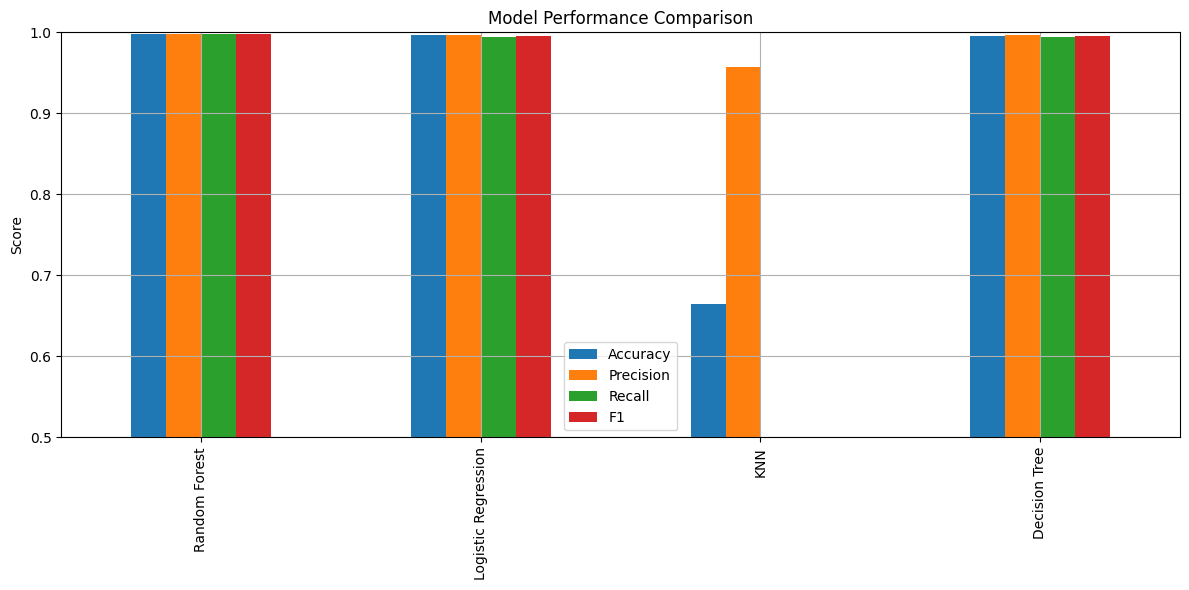

In [20]:
results_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1"]).T
results_df.plot(kind='bar', figsize=(12, 6), title="Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

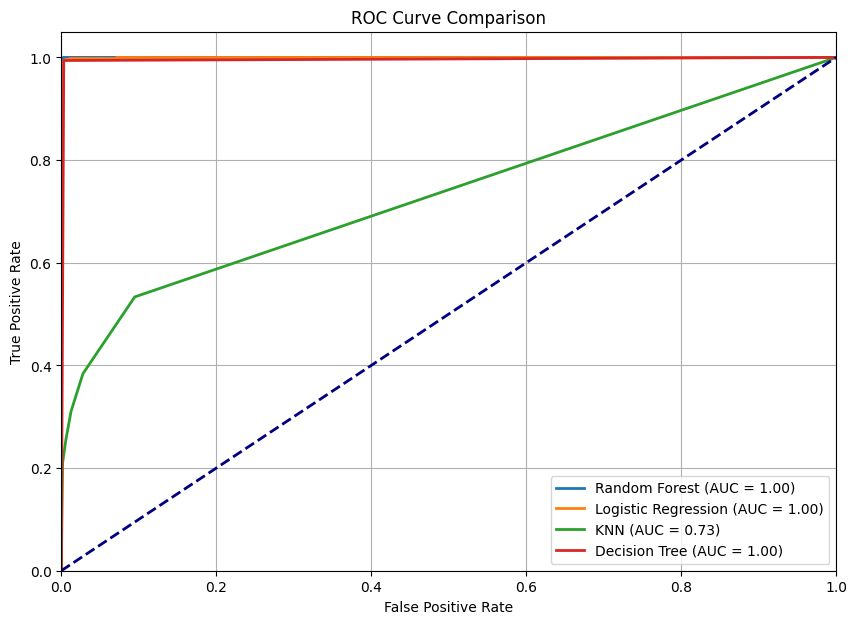

In [28]:
# ROC Curve for all models
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # For models without predict_proba, use decision_function or skip
        continue
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

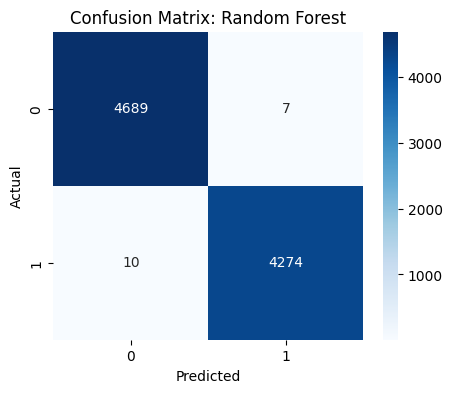

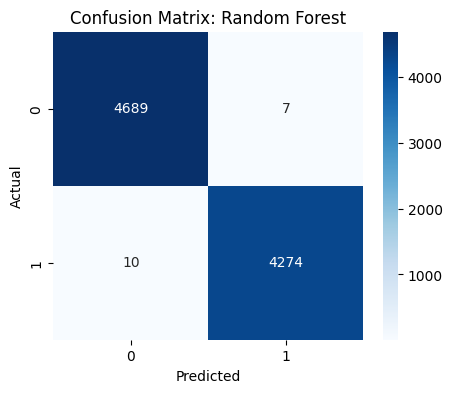

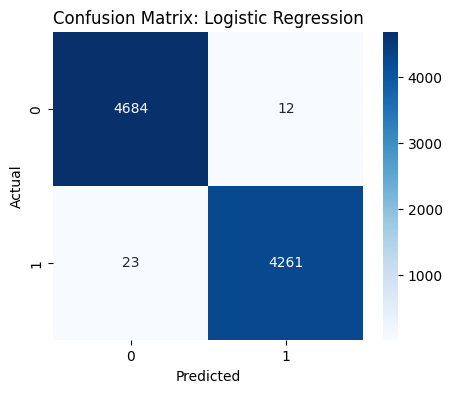

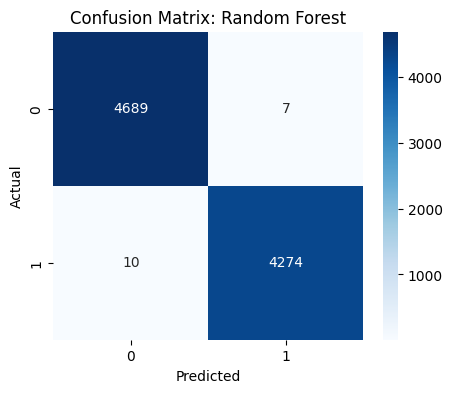

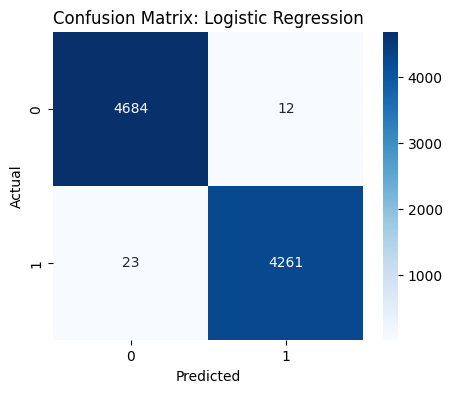

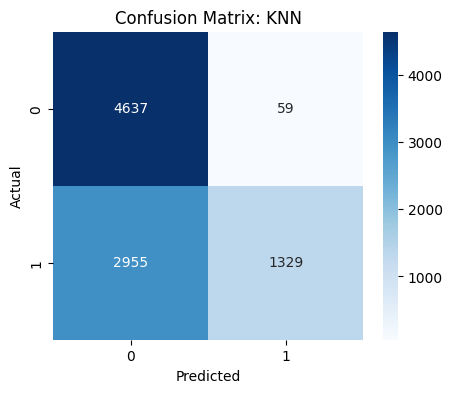

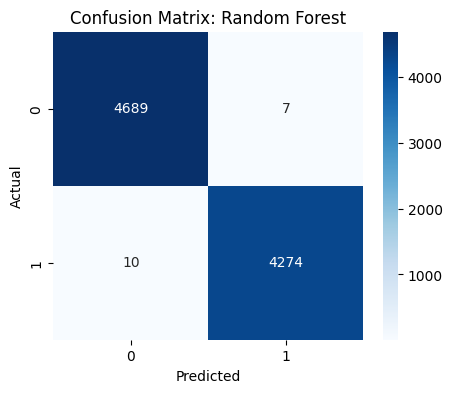

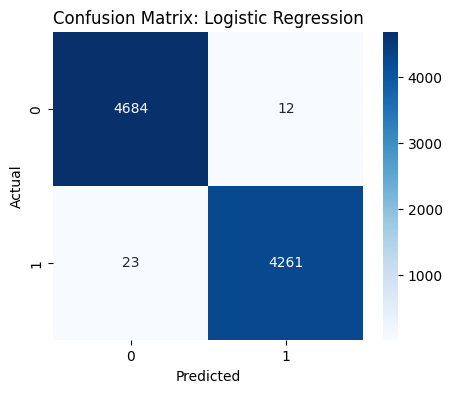

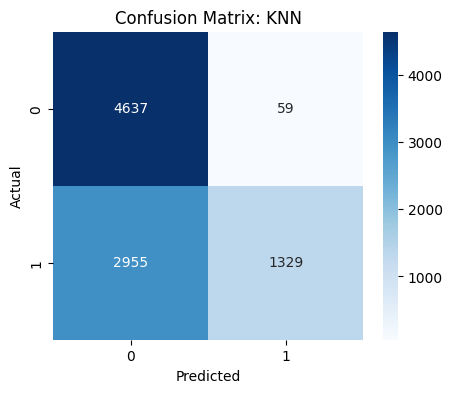

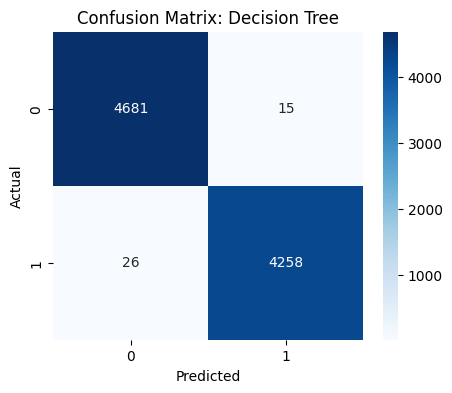

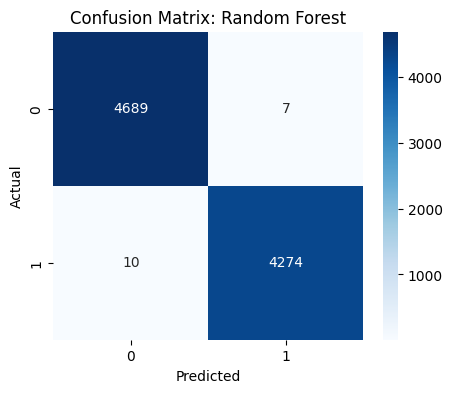

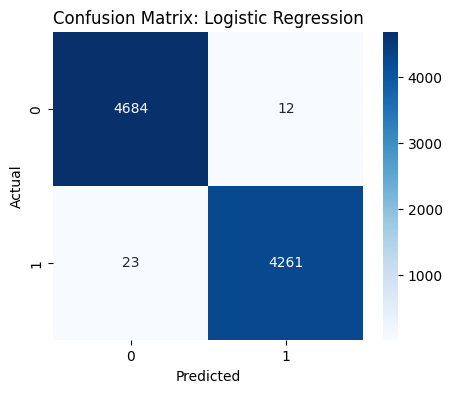

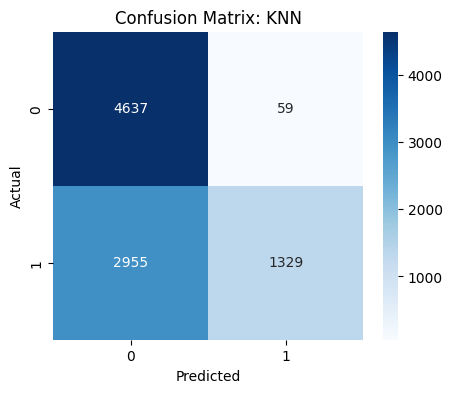

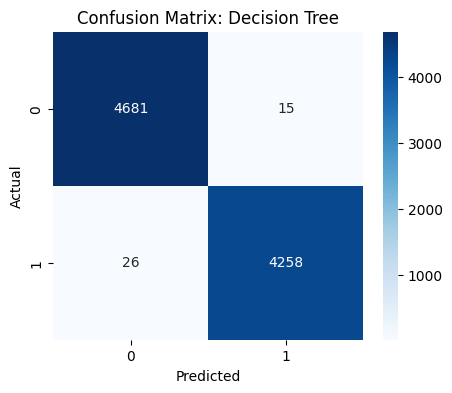

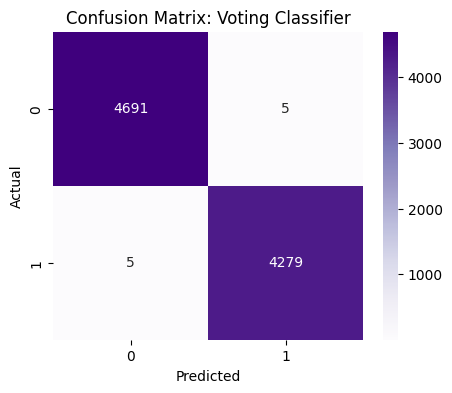

In [21]:
# Plot confusion matrix for each model
from sklearn.metrics import confusion_matrix
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot confusion matrix for ensemble voting classifier
if 'voting_model' in locals() or 'voting_model' in globals():
    y_vote = voting_model.predict(X_test_scaled)
    cm_vote = confusion_matrix(y_test, y_vote)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_vote, annot=True, fmt='d', cmap='Purples')
    plt.title("Confusion Matrix: Voting Classifier")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()